In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import tqdm

%matplotlib widget

In [2]:
# Constants in SI units
q = 1.60217662e-19      # Elementary charge (C)
m_e = 9.10938356e-31    # Electron mass (kg)
eps0 = 8.85418782e-12   # Vacuum permittivity (F/m)
hbar = 1.0545718e-34    # Reduced Planck constant (J.s)
k_B = 1.380649e-23      # Boltzmann constant (J/K)

In [3]:
# ---------------------------------------------
# Define functions for material parameters
# ---------------------------------------------
def a_func(x):
    a = 3.189 + (3.112 - 3.189) * x  # Lattice constant a (Angstrom)
    # print(f"Lattice constant a: {a:.5f} Å")
    return (3.189 + (3.112 - 3.189) * x) * 1e-10  # Lattice constant a (m)

def c_func(x):
    c = 5.185 + (4.982 - 5.185) * x  # Lattice constant c (Angstrom)
    # print(f"Lattice constant c: {c:.5f} Å")
    return (5.185 + (4.982 - 5.185) * x) * 1e-10  # Lattice constant c (m)

def m_star_func(x):
    return (0.2 + (0.4 - 0.2) * x) * m_e  # Effective mass (kg)

def epsilon_s_func(x):
    return 8.9 + (8.5 - 8.9) * x  # Static dielectric constant

def epsilon_inf_func(x):
    return 5.35 + (4.6 - 5.35) * x  # High-frequency dielectric constant

def Volume_unitcell_func(x):
    vol = (np.sqrt(3) / 2) * a_func(x)**2 * c_func(x)  # Unit cell volume (m³)
    # print(f"Volume of unit cell: {vol:.5e} m³")
    return vol

def Eg_AlGaN_func(x):
    return 6.28*x + 3.42*(1-x) -1*x*(1-x)  # Bandgap energy (eV)

def del_EC_func(x):
    return 0.63*(Eg_AlGaN_func(x) - Eg_AlGaN_func(0)) * 1.6e-19  # Conduction band offset (J)

# ---------------------------------------------
# Function 1: Interface Roughness Scattering (IRF)
# ---------------------------------------------
def mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s):
    """
    Calculate mobility limited by interface roughness scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        L: Roughness length scale (m)
        delta: Roughness amplitude (m)
        m_star: Effective mass (kg)
        epsilon_s: Static dielectric constant (dimensionless)
    """
    k_F = np.sqrt(2 * np.pi * n_2DEG)  # Fermi wavevector (1/m)
    q_TF = (m_star * q**2) / (2 * np.pi * epsilon_s * eps0 * hbar**2)  # Thomas-Fermi wavevector (1/m)
    
    # Define screening function
    def G(q, b):
        return (1 / 8) * ((2 * (b / (b + q))**3) + 3 * (b / (b + q))**2 + 3 * (b / (b + q)))
    
    b = np.cbrt(33 * m_star * (q**2) * n_2DEG / (8 * (hbar**2) * eps0 * epsilon_s))
    
    # Define integrand for scattering
    def integrand(u):
        numerator = u**4 * np.exp(-(L * k_F * u)**2)
        denominator = (u + q_TF * G(u, b) / (2 * k_F))**2 * np.sqrt(1 - u**2)
        return numerator / denominator
    
    integral, _ = quad(integrand, 0, 1)
    
    # Calculate inverse relaxation time (1/tau)
    tau_ifr_inv = (m_star * (q**2 * delta * L * n_2DEG)**2 / (8 * (eps0 * epsilon_s)**2 * hbar**3)) * integral
    
    # Calculate mobility
    mu_irf = q / (tau_ifr_inv * m_star)
    return mu_irf * 1e4  # Convert to cm^2/(V·s)


# ---------------------------------------------
# Function 2: Optical Phonon Scattering (POP)
# ---------------------------------------------
def mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_inf, m_star):
    """
    Calculate mobility limited by polar optical phonon scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        omega_0: Optical phonon frequency (rad/s)
        epsilon_s: Static dielectric constant (dimensionless)
        epsilon_inf: High-frequency dielectric constant (dimensionless)
        m_star: Effective mass (kg)
    """
    eps_p = 2 / ((1 / epsilon_s) + (1 / epsilon_inf))  # Harmonic mean of dielectric constants
    Q0 = np.sqrt(2 * m_star * omega_0 / hbar)
    z = np.pi * hbar**2 * n_2DEG / (m_star * T * k_B)
    
    # Bose-Einstein distribution function
    N_B = 1 / (np.exp(hbar * omega_0 / (k_B * T)) - 1)
    
    # Screening form factor G(Q0)
    b = np.cbrt(33 * m_star * (q**2) * n_2DEG / (8 * (hbar**2) * eps0 * epsilon_s))
    G_Q0 = b * (8 * b**2 + 9 * Q0 * b + 3 * Q0**2) / (8 * (Q0 + b)**3)
    
    # Mobility formula
    mu_pop = (2 * Q0 * hbar**2 * (1 + (1 - np.exp(-z)) / z) * eps0 * eps_p) / (q * m_star**2 * omega_0 * N_B * G_Q0)
    return mu_pop * 1e4  # Convert to cm^2/(V·s)

# ---------------------------------------------
# Function 3: Background Impurity Scattering
# ---------------------------------------------
def mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star):
    """
    Calculate mobility limited by impurity scattering.
    Parameters:
        T: Temperature (K)
        n_2DEG: 2D carrier density (m^-2)
        N_imp: Impurity density (m^-3)
        epsilon_s: Static dielectric constant (dimensionless)
        m_star: Effective mass (kg)
    """
    prefactor = (
        4 * (2 * np.pi)**(5 / 2) * hbar**3 * (eps0 * epsilon_s)**2
    ) / ((m_star**2) * q**3)
    
    # Mobility formula
    mu_imp = prefactor * (n_2DEG**(3 / 2) / N_imp)
    return mu_imp * 1e4  # Convert to cm^2/(V·s)


# ---------------------------------------------
# Function 4: Dislocation Scattering
# ---------------------------------------------
def mobility_dislocation(T, n_2DEG, N_DIS, f_DIS, m_star, q, epsilon_0, epsilon_s, c0):
    """
    Calculate mobility limited by dislocation scattering.

    Parameters:
        n_2DEG (float): 2D carrier density (m^-2).
        N_DIS (float): Density of dislocation scattering centers (m^-2).
        f_DIS (float): Form factor (dimensionless).
        m_star (float): Effective mass of the electron (kg).
        q (float): Elementary charge (C).
        epsilon_0 (float): Vacuum permittivity (F/m).
        epsilon_s (float): Static dielectric constant.
        c0 (float): Lattice constant (m).

    Returns:
        float: Mobility limited by dislocation scattering (cm^2/V·s).
    """

    # Derived parameters
    k_F = np.sqrt(2 * np.pi * n_2DEG)  # Fermi wavevector (1/m)
    q_TF = (m_star * q**2) / (2 * np.pi * epsilon_s * epsilon_0 * hbar**2)  # Thomas-Fermi wavevector (1/m)

    # Define the integrand
    def integrand(u):
        return 1 / ((u + q_TF / (2 * k_F))**2 * np.sqrt(1 - u**2))

    # Perform the integration
    integral_result = quad(integrand, 0, 1)

    # Scattering rate calculation
    scattering_rate = (
        (q**4 * m_star * N_DIS * f_DIS**2) /
        (c0**2 * (epsilon_0 * epsilon_s)**2 * hbar**3 * 4 * np.pi * k_F**4)
    ) * float(integral_result[0])

    # Scattering time (τ_DIS)
    scattering_time = 1 / scattering_rate

    # Mobility calculation
    mobility = (q * scattering_time) / m_star  # Mobility in m^2/V·s
    return mobility * 1e4  # Convert to cm^2/V·s


# ---------------------------------------------
# Function 5: Alloy Disorder Scattering : Equation taken from "DJ Thesis"
# ---------------------------------------------

def mobility_alloy_disorder_barrier_penetration(T, n_2DEG, x, y, m_star, epsilon_s, Volume_unitcell, delta_V0=2.0 * 1.6e-19, del_EC=2.1 * 1.6e-19, P_b = 0.000777217):
    
    """
    Calculate the mobility limited by alloy disorder scattering.

    Parameters:
        T (float): Temperature (K).
        x (float): Barrier Alloy fraction (dimensionless, between 0 and 1).
        y (float): Channel Alloy fraction (dimensionless, between 0 and 1).
        n_2DEG (float): 2D electron concentration (m^-2).
        delta_V0 (float): Alloy disorder potential energy (J), default is 2.0 eV.

    Returns:
        float: Mobility limited by alloy disorder scattering (cm^2/V·s).
    """
    # # b = (33 * q**2 * m_star * n_2DEG / (8 * eps0 * epsilon_s * hbar**2))**(1/3)
    # b = np.cbrt(33 * m_star * (q**2) * n_2DEG / (8 * (hbar**2) * eps0 * epsilon_s))
    K_b = 2*np.sqrt(2*m_star*del_EC/hbar**2)
    # z0 = 2/(b+K_b*(m_star_func(x)/m_star_func(y)))
    # print(f"m_a = {m_star_func(x)}\t m_b = {m_star_func(y)}")
    # N = np.sqrt(b**3 / 2) * 1/np.sqrt(1+ b*z0 + 0.5 * b**2 * z0**2 * (1+b/K_b))
    # P_b = N**2 * z0**2/K_b/2

    # P_b = 0.000777217
    # P_b= 0.21

    # scattering_time_inverse = m_star * Volume_unitcell * delta_V0**2 * (1 - x) * x * P_b**2 * K_b / (2* q**2 * hbar**3)
    # scattering_time = 1 / scattering_time_inverse
    # mobility = q * scattering_time / m_star
    # Calculate mobility
    # numerator = q * hbar**3 * 16
    # denominator = (m_star * delta_V0)**2 * Volume_unitcell * (1 - x) * x * 3 * b

    # Nz0 = np.sqrt(0.065*K_b)
    # print(f"Nz0 est.: {Nz0}, Nz0: {N*z0}")

    # print(f"P_b: {P_b*100}")

    numerator = 2 * q * hbar**3
    denominator = (m_star * delta_V0)**2 * Volume_unitcell * (1 - x)*x * K_b * P_b**2
    mobility = numerator / denominator
    
    return mobility * 1e4  # Convert to cm²/V·s

# ---------------------------------------------
# Function 5: Alloy Disorder Scattering : Equation taken from "Srabanti Paper"
# ---------------------------------------------

def mobility_alloy_disorder_only_channel(T, n_2DEG, x, y, m_star, epsilon_s, Volume_unitcell, delta_V0=2.0 * 1.6e-19, del_EC=2.1 * 1.6e-19):
    
    """
    Calculate the mobility limited by alloy disorder scattering.

    Parameters:
        T (float): Temperature (K).
        x (float): Barrier Alloy fraction (dimensionless, between 0 and 1).
        y (float): Channel Alloy fraction (dimensionless, between 0 and 1).
        n_2DEG (float): 2D electron concentration (m^-2).
        delta_V0 (float): Alloy disorder potential energy (J), default is 2.0 eV.

    Returns:
        float: Mobility limited by alloy disorder scattering (cm^2/V·s).
    """

    b = np.cbrt(33 * m_star * (q**2) * n_2DEG / (8 * (hbar**2) * eps0 * epsilon_s))

    # Calculate mobility
    numerator = q * hbar**3 * 16
    denominator = (m_star * delta_V0)**2 * Volume_unitcell * (1 - x) * x * 3 * b
    mobility = numerator / denominator
    
    return mobility * 1e4  # Convert to cm²/V·s



# ---------------------------------------------
# Function 6: Remote Impurity Scattering
# ---------------------------------------------

def impurity_scattering_mobility(T, n_2DEG, n_imp, d):
    """
    Calculate and plot mobility due to impurity scattering as a function of distance between 2D electron gas and impurities.

    Parameters:
        T (float): Temperature (K).
        n_2DEG (float): 2D electron gas concentration (m^-2).
        n_imp (float): Impurity concentration (m^-2).
        d (float): Distance between 2D electron gas and impurities (m).

    Returns:
        float: Mobility limited by alloy disorder scattering (cm^2/V·s).

    """
    
    # Calculate Fermi wavevector
    k_F = np.sqrt(2 * np.pi * n_2DEG)
    
    # Define mobility calculation
    mobility =  (8 * q / (np.pi * hbar)) * (k_F * d)**3 / n_imp

    return mobility * 1e4  # Convert to cm²/V·s


def mobility_combined_func(T, n_2DEG, x, y, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0, Pb=0.000777217, del_EC=2.1 * 1.6e-19):
    """
    Calculate the combined mobility of a 2D electron gas due to various scattering mechanisms.

    Parameters:
        T (float): Temperature (K).
        n_2DEG (float): 2D electron gas concentration (m^-2).
        x (float): Alloy fraction (dimensionless, between 0 and 1).
        N_imp (float): Impurity density (m^-3).
        N_dis (float): Dislocation density (m^-2).
        f_dis (float): Form factor (dimensionless).
        N_imp_ionized (float): Ionized impurity density (m^-2).
        d_ionized (float): Distance between 2D electron gas and ionized impurities (m).
        delta_V0 (float): Alloy disorder potential energy (J).

    Returns:
        float: Combined mobility of a 2D electron gas (cm^2/V·s).
    """
    # Calculate material parameters
    m_star = m_star_func(x)
    epsilon_s = epsilon_s_func(x)  # Static dielectric constant

    # Calculate mobilities due to different scattering mechanisms
    mu_irf = mobility_irf(T, n_2DEG, L, delta, m_star, epsilon_s)
    mu_imp = mobility_imp(T, n_2DEG, N_imp, epsilon_s, m_star)
    mu_dis = mobility_dislocation(T, n_2DEG, N_dis, f_dis, m_star, q, eps0, epsilon_s, c_func(x))
    mu_pop = mobility_pop(T, n_2DEG, omega_0, epsilon_s, epsilon_s, m_star)
    mu_alloy_only_channel = mobility_alloy_disorder_only_channel(T, n_2DEG, x, y, m_star, epsilon_s, Volume_unitcell_func(x), delta_V0, del_EC)
    mu_alloy_only_barrier_penetration = mobility_alloy_disorder_barrier_penetration(T, n_2DEG, x, y, m_star, epsilon_s, Volume_unitcell_func(x), delta_V0, del_EC, Pb)

    mu_remote_imp = impurity_scattering_mobility(T, n_2DEG, N_imp_ionized, d_ionized)
    mu_remote_imp_barrier = impurity_scattering_mobility(T, n_2DEG, N_imp_barrier, d_imp_barrier)

    mu_alloy = 1/(1/mu_alloy_only_barrier_penetration + 1/mu_alloy_only_channel)

    # Calculate the combined mobility
    mu_combined_inv = 1 / mu_irf + 1 / mu_imp + 1 / mu_dis + 1 / mu_pop + 1 / mu_alloy_only_barrier_penetration + 1 / mu_remote_imp + 1/mu_remote_imp_barrier + 1/mu_alloy_only_channel
    mu_combined = 1 / mu_combined_inv

    return mu_combined, mu_irf, mu_imp, mu_dis, mu_pop, mu_alloy, mu_remote_imp, mu_remote_imp_barrier, mu_alloy_only_barrier_penetration, mu_alloy_only_channel

In [4]:
# Example usage:
x = 0.65
y = 0.85

T = 300  # Temperature (K)
m_star = m_star_func(x)
epsilon_s = epsilon_s_func(x)  # Static dielectric constant
epsilon_inf = epsilon_inf_func(x)  # Static dielectric constant


n_2DEG = 1e17           # Carrier density (m^-2)
N_imp = 5e20            # Impurity density (m^-3)
omega_0 = 1.4585e+14    # Optical phonon frequency (rad/s)

L = 20e-10  # Roughness length scale (m)
delta = 3e-10  # Roughness amplitude (m)

N_dis = 1e12  # Dislocation density (m^-2)
f_dis = 0.5  # Form factor
E_POP = 0.096  # Optical phonon energy (eV)

N_imp_ionized = 1e17  # Ionized impurity density (m^-2)
d_ionized = 150e-9  # Distance between 2D electron gas and ionized impurities (m)

delta_V0 = 1.10 * 1.6e-19  # Alloy disorder potential energy (J)

N_imp_barrier = 2.24e24*20e-9  # Impurity density (m^-2)
N_imp_barrier = 2.0e24*20e-9  # Impurity density (m^-2)

d_imp_barrier = 1e-9  # Distance between 2D electron gas and impurities (m)


In [5]:
mu_combined, mu_irf, mu_imp, mu_dis, mu_pop, mu_alloy, mu_remote_imp, mu_remote_imp_barrier, mu_alloy_only_barrier_penetration, mu_alloy_only_channel = mobility_combined_func(T, n_2DEG, x, y, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0, Pb=0.0004165755688333088, del_EC=0.8184912 * 1.6e-19)
print(f"Mobility (Combined): {mu_combined} cm^2/V·s")
print(f"Mobility (IRF): {mu_irf} cm^2/V·s")
print(f"Mobility (Impurity): {mu_imp} cm^2/V·s")
print(f"Mobility (Dislocation): {mu_dis} cm^2/V·s")
print(f"Mobility (POP): {mu_pop} cm^2/V·s")
print(f"Mobility (Alloy Disorder): {mu_alloy} cm^2/V·s")
print(f"Mobility (Remote Impurity): {mu_remote_imp} cm^2/V·s")
print(f"Mobility (Remote Impurity Barrier): {mu_remote_imp_barrier} cm^2/V·s")
print(f"Mobility (Alloy Disorder Barrier Penetration): {mu_alloy_only_barrier_penetration} cm^2/V·s")
print(f"Mobility (Alloy Disorder Only Channel): {mu_alloy_only_channel} cm^2/V·s")

Mobility (Combined): 132.6152988604294 cm^2/V·s
Mobility (IRF): 14439.989414231059 cm^2/V·s
Mobility (Impurity): 4623342.180486793 cm^2/V·s
Mobility (Dislocation): 1232530.457592854 cm^2/V·s
Mobility (POP): 876.4641670034644 cm^2/V·s
Mobility (Alloy Disorder): 235.1041594452231 cm^2/V·s
Mobility (Remote Impurity): 650306253.2416193 cm^2/V·s
Mobility (Remote Impurity Barrier): 481.708335734533 cm^2/V·s
Mobility (Alloy Disorder Barrier Penetration): 148210282.50022528 cm^2/V·s
Mobility (Alloy Disorder Only Channel): 235.10453238866899 cm^2/V·s


In [30]:
n_2DEG_arr = np.linspace(1e16, 1e18, 1000)
N_imp_ionized = 1e17
d_imp_barrier_arr = np.array([0.5e-9, 1e-9, 1.5e-9, 2e-9, 2.5e-9, 3e-9])
# d_imp_barrier_arr = np.array([1e-13, 1.0e-9, 2.0e-9])
del_EC_arr = [0.818491 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19]
Pb_arr = [0.008002832954300423, 0.0004165755688333088, 1.87852005002513e-05, 7.578693392851842e-07, 2.729944132738147e-08, 8.835064657525907e-10]
delta_V0_arr = [1.0 * 1.6e-19, 1.0 * 1.6e-19, 1.0 * 1.6e-19, 1.0 * 1.6e-19, 1.0 * 1.6e-19, 1.0 * 1.6e-19]

mobility = []
u_remote_impurity_arr = []
u_dislocation_arr = []
u_background_impurity_arr = []
u_alloy_arr = []
u_pop_arr = []
u_irf_arr = []
u_remote_barrier_arr = []
u_alloy_channel_arr = []
u_alloy_barrier_arr = []

for d_imp_barrier, del_EC, Pb, delta_V0 in zip(d_imp_barrier_arr, del_EC_arr, Pb_arr, delta_V0_arr):
    mobility_temp = []
    u_remote_impurity_arr_temp = []
    u_dislocation_arr_temp = []
    u_background_impurity_arr_temp = []
    u_alloy_arr_temp = []
    u_pop_arr_temp = []
    u_irf_arr_temp = []
    u_remote_barrier_arr_temp = []
    u_alloy_channel_arr_temp = []
    u_alloy_barrier_arr_temp = []
    
    print(f"Distance between 2D electron gas and impurities: {d_imp_barrier*1e9:.1e} nm")

    for n_2DEG in tqdm.tqdm(n_2DEG_arr):
        mu_combined, mu_irf, mu_imp, mu_dis, mu_pop, mu_alloy, mu_remote_imp, mu_remote_imp_barrier, mu_alloy_only_barrier_penetration, mu_alloy_only_channel = mobility_combined_func(T, n_2DEG, x, y, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0, Pb=Pb, del_EC=del_EC)
        
        mobility_temp.append(mu_combined)
        u_remote_impurity_arr_temp.append(mu_remote_imp)
        u_dislocation_arr_temp.append(mu_dis)
        u_background_impurity_arr_temp.append(mu_imp)
        u_alloy_arr_temp.append(mu_alloy)
        u_pop_arr_temp.append(mu_pop)
        u_irf_arr_temp.append(mu_irf)
        u_remote_barrier_arr_temp.append(mu_remote_imp_barrier)
        u_alloy_channel_arr_temp.append(mu_alloy_only_channel)
        u_alloy_barrier_arr_temp.append(mu_alloy_only_barrier_penetration)

    mobility.append(mobility_temp)
    u_remote_impurity_arr.append(u_remote_impurity_arr_temp)
    u_dislocation_arr.append(u_dislocation_arr_temp)
    u_background_impurity_arr.append(u_background_impurity_arr_temp)
    u_alloy_arr.append(u_alloy_arr_temp)
    u_pop_arr.append(u_pop_arr_temp)
    u_irf_arr.append(u_irf_arr_temp)
    u_remote_barrier_arr.append(u_remote_barrier_arr_temp)
    u_alloy_channel_arr.append(u_alloy_channel_arr_temp)
    u_alloy_barrier_arr.append(u_alloy_barrier_arr_temp)


print(f'Shape of mobility: {np.shape(mobility)}\nShape of n_2DEG_arr: {np.shape(n_2DEG_arr)}\nShape of u_alloy_arr: {np.shape(u_alloy_arr)}\nShape of u_remote_barrier_arr: {np.shape(u_remote_barrier_arr)}\nShape of u_alloy_channel_arr: {np.shape(u_alloy_channel_arr)}\nShape of u_alloy_barrier_arr: {np.shape(u_alloy_barrier_arr)}')


mobility = np.array(mobility)
u_alloy_arr = np.array(u_alloy_arr)
u_remote_barrier_arr = np.array(u_remote_barrier_arr)

Distance between 2D electron gas and impurities: 5.0e-01 nm


100%|██████████| 1000/1000 [00:01<00:00, 660.67it/s]


Distance between 2D electron gas and impurities: 1.0e+00 nm


100%|██████████| 1000/1000 [00:01<00:00, 722.61it/s]


Distance between 2D electron gas and impurities: 1.5e+00 nm


100%|██████████| 1000/1000 [00:01<00:00, 723.80it/s]


Distance between 2D electron gas and impurities: 2.0e+00 nm


100%|██████████| 1000/1000 [00:01<00:00, 694.91it/s]


Distance between 2D electron gas and impurities: 2.5e+00 nm


100%|██████████| 1000/1000 [00:01<00:00, 689.47it/s]


Distance between 2D electron gas and impurities: 3.0e+00 nm


100%|██████████| 1000/1000 [00:01<00:00, 711.77it/s]

Shape of mobility: (6, 1000)
Shape of n_2DEG_arr: (1000,)
Shape of u_alloy_arr: (6, 1000)
Shape of u_remote_barrier_arr: (6, 1000)
Shape of u_alloy_channel_arr: (6, 1000)
Shape of u_alloy_barrier_arr: (6, 1000)


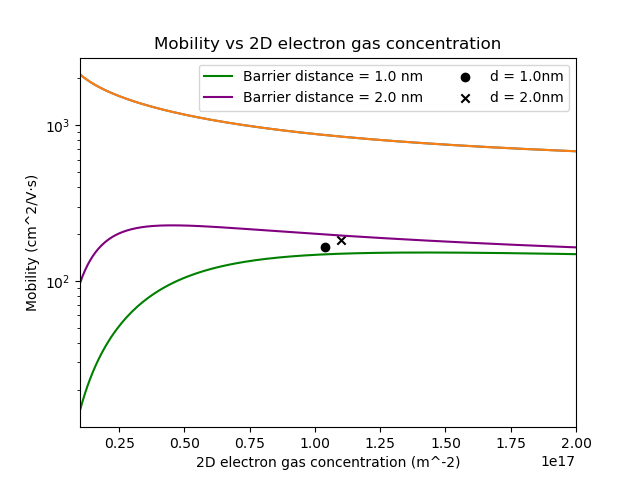

In [32]:
plt.close()
plt.figure()

C = ['blue', 'green', 'red', 'purple', 'orange', 'pink']
for i,d in enumerate(d_imp_barrier_arr):
    if(d==0.5e-9 or d==1.5e-9 or d==2.5e-9 or d==3.0e-9): continue
    plt.plot(n_2DEG_arr, mobility[i], label=f'Barrier distance = {d*1e9} nm', color=C[i])
    # plt.plot(n_2DEG_arr, u_alloy_arr[i], label='Alloy Disorder', alpha=0.5, color=C[i], linestyle='--')
    # plt.plot(n_2DEG_arr, u_remote_barrier_arr[i], label='Barrier Scattering', color=C[i], linestyle='-.')
    # plt.plot(n_2DEG_arr, u_alloy_arr[i], alpha=0.5, color=C[i], linestyle='--')
    # plt.plot(n_2DEG_arr, u_remote_barrier_arr[i], color=C[i], linestyle='-.')
    plt.plot(n_2DEG_arr, u_pop_arr[i])

plt.scatter(1.04e17, 165, label=f'd = 1.0nm', color='black')
plt.scatter(1.1e17, 182, label=f'd = 2.0nm', color='black', marker='x')
plt.xlabel('2D electron gas concentration (m^-2)')
plt.ylabel('Mobility (cm^2/V·s)')
plt.title('Mobility vs 2D electron gas concentration')
plt.yscale('log')
plt.xlim(1e16, 2e17)
# plt.xscale('log')
plt.legend(ncol=2)
plt.show()

In [8]:
# Find the peak mobility
max_mobility_1nm = np.max(mobility[1])
max_mobility_index_1nm = np.argmax(mobility[1])
print(f"Peak mobility 1nm: {max_mobility_1nm:.2f} cm²/V·s at n_2DEG = {n_2DEG_arr[max_mobility_index_1nm]:.2e} m⁻²")

max_mobility_1o5nm = np.max(mobility[2])
max_mobility_index_1o5nm = np.argmax(mobility[2])
print(f"Peak mobility 1.5nm: {max_mobility_1o5nm:.2f} cm²/V·s at n_2DEG = {n_2DEG_arr[max_mobility_index_1o5nm]:.2e} m⁻²")

max_mobility_2nm = np.max(mobility[3])
max_mobility_index_2nm = np.argmax(mobility[3])
print(f"Peak mobility 2nm: {max_mobility_2nm:.2f} cm²/V·s at n_2DEG = {n_2DEG_arr[max_mobility_index_2nm]:.2e} m⁻²")

Peak mobility 1nm: 148.52 cm²/V·s at n_2DEG = 1.40e+17 m⁻²
Peak mobility 1.5nm: 187.60 cm²/V·s at n_2DEG = 7.05e+16 m⁻²
Peak mobility 2nm: 221.80 cm²/V·s at n_2DEG = 4.46e+16 m⁻²


In [9]:
print(f"Shape of mobility: {np.array(mobility).shape}\nShape of n_2DEG_arr: {n_2DEG_arr.shape}\nShape of u_remote_barrier_arr: {np.array(u_remote_barrier_arr).shape}\nShape of u_alloy_channel_arr: {np.array(u_alloy_channel_arr).shape}\nShape of u_alloy_barrier_arr: {np.array(u_alloy_barrier_arr).shape}\nShape of u_alloy_arr: {np.array(u_alloy_arr).shape}\nShape of u_remote_impurity_arr: {np.array(u_remote_impurity_arr).shape}\nShape of u_dislocation_arr: {np.array(u_dislocation_arr).shape}\nShape of u_background_impurity_arr: {np.array(u_background_impurity_arr).shape}\nShape of u_pop_arr: {np.array(u_pop_arr).shape}\nShape of u_irf_arr: {np.array(u_irf_arr).shape}")

Shape of mobility: (6, 1000)
Shape of n_2DEG_arr: (1000,)
Shape of u_remote_barrier_arr: (6, 1000)
Shape of u_alloy_channel_arr: (6, 1000)
Shape of u_alloy_barrier_arr: (6, 1000)
Shape of u_alloy_arr: (6, 1000)
Shape of u_remote_impurity_arr: (6, 1000)
Shape of u_dislocation_arr: (6, 1000)
Shape of u_background_impurity_arr: (6, 1000)
Shape of u_pop_arr: (6, 1000)
Shape of u_irf_arr: (6, 1000)


In [33]:
for i, d_imp_barrier in enumerate(d_imp_barrier_arr):
    data = np.column_stack((
        n_2DEG_arr,
        mobility[i],
        u_remote_impurity_arr[i],
        u_dislocation_arr[i],
        u_background_impurity_arr[i],
        u_alloy_arr[i],
        u_pop_arr[i],
        u_irf_arr[i],
        u_remote_barrier_arr[i],
        u_alloy_barrier_arr[i],
        u_alloy_channel_arr[i]
    ))

    # Save to CSV file
    header = [
        "n_2DEG",
        "Total Mobility",
        "Remote Impurity Mobility",
        "Dislocation Mobility",
        "Background Impurity Mobility",
        "Alloy Disorder Mobility",
        "Optical Phonon Mobility",
        "Interface Roughness Mobility",
        "Remote Barrier Mobility",
        "Alloy Disorder Barrier Penetration",
        "Alloy Disorder Only Channel"
    ]

    filename = f"mobility_data_d_imp_barrier_{d_imp_barrier*1e9:.1f}nm.csv"
    np.savetxt(filename, data, delimiter=",", header=",".join(header), comments="")
    print(f"Data saved to {filename}")


Data saved to mobility_data_d_imp_barrier_0.5nm.csv
Data saved to mobility_data_d_imp_barrier_1.0nm.csv
Data saved to mobility_data_d_imp_barrier_1.5nm.csv
Data saved to mobility_data_d_imp_barrier_2.0nm.csv
Data saved to mobility_data_d_imp_barrier_2.5nm.csv
Data saved to mobility_data_d_imp_barrier_3.0nm.csv


In [34]:
mu_combined, mu_irf, mu_imp, mu_dis, mu_pop, mu_alloy, mu_remote_imp, mu_remote_imp_barrier, mu_alloy_only_barrier_penetration, mu_alloy_only_channel = mobility_combined_func(T, 1.04e17, x, y, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, 1e-9, 1.6e-19, L, delta, omega_0, Pb=0.0004165755688333088, del_EC=0.818584 * 1.6e-19)
print(f"Mobility (Combined): {mu_combined} cm^2/V·s")
print(f"Mobility (IRF): {mu_irf} cm^2/V·s")
print(f"Mobility (Impurity): {mu_imp} cm^2/V·s")
print(f"Mobility (Dislocation): {mu_dis} cm^2/V·s")
print(f"Mobility (POP): {mu_pop} cm^2/V·s")
print(f"Mobility (Alloy Disorder): {mu_alloy} cm^2/V·s")
print(f"Mobility (Remote Impurity): {mu_remote_imp} cm^2/V·s")
print(f"Mobility (Remote Impurity Barrier): {mu_remote_imp_barrier} cm^2/V·s")
print(f"Mobility (Alloy Disorder Barrier Penetration): {mu_alloy_only_barrier_penetration} cm^2/V·s")
print(f"Mobility (Alloy Disorder Only Channel): {mu_alloy_only_channel} cm^2/V·s")

Mobility (Combined): 148.1356769907447 cm^2/V·s
Mobility (IRF): 13958.923027842104 cm^2/V·s
Mobility (Impurity): 4903498.495234305 cm^2/V·s
Mobility (Dislocation): 1297719.5546093052 cm^2/V·s
Mobility (POP): 862.7215225811606 cm^2/V·s
Mobility (Alloy Disorder): 280.7811265355002 cm^2/V·s
Mobility (Remote Impurity): 689712249.2188089 cm^2/V·s
Mobility (Remote Impurity Barrier): 510.8979623843031 cm^2/V·s
Mobility (Alloy Disorder Barrier Penetration): 179324276.27848923 cm^2/V·s
Mobility (Alloy Disorder Only Channel): 280.7815661757213 cm^2/V·s


In [16]:
n_2DEG_arr = np.linspace(1e16, 2e17, 1000)
N_imp_ionized = 1e17
d_imp_barrier_arr = np.array([0.5e-9, 1e-9, 1.5e-9, 2e-9, 2.5e-9, 3e-9])
# d_imp_barrier_arr = np.array([1e-13, 1.0e-9, 2.0e-9])
del_EC_arr = [0.818491 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19, 0.818584 * 1.6e-19]
Pb_arr = [0.008002832954300423, 0.0004165755688333088, 1.87852005002513e-05, 7.578693392851842e-07, 2.729944132738147e-08, 8.835064657525907e-10]
delta_V0_arr = [1.02 * 1.6e-19, 1.02 * 1.6e-19, 1.02 * 1.6e-19, 1.02 * 1.6e-19, 1.02 * 1.6e-19, 1.02 * 1.6e-19]


mobility = []
u_remote_impurity_arr = []
u_dislocation_arr = []
u_background_impurity_arr = []
u_alloy_arr = []
u_pop_arr = []
u_irf_arr = []
u_remote_barrier_arr = []
u_alloy_channel_arr = []
u_alloy_barrier_arr = []

for d_imp_barrier, del_EC, Pb, delta_V0 in zip(d_imp_barrier_arr, del_EC_arr, Pb_arr, delta_V0_arr):
    mobility_temp = []
    u_remote_impurity_arr_temp = []
    u_dislocation_arr_temp = []
    u_background_impurity_arr_temp = []
    u_alloy_arr_temp = []
    u_pop_arr_temp = []
    u_irf_arr_temp = []
    u_remote_barrier_arr_temp = []
    u_alloy_channel_arr_temp = []
    u_alloy_barrier_arr_temp = []
    
    print(f"Distance between 2D electron gas and impurities: {d_imp_barrier*1e9:.1e} nm")

    for n_2DEG in tqdm.tqdm(n_2DEG_arr):
        mu_combined, mu_irf, mu_imp, mu_dis, mu_pop, mu_alloy, mu_remote_imp, mu_remote_imp_barrier, mu_alloy_only_barrier_penetration, mu_alloy_only_channel = mobility_combined_func(T, n_2DEG, x, y, N_imp, N_dis, f_dis, N_imp_ionized, N_imp_barrier, d_ionized, d_imp_barrier, delta_V0, L, delta, omega_0, Pb=Pb, del_EC=del_EC)
        
        mobility_temp.append(mu_combined)
        u_remote_impurity_arr_temp.append(mu_remote_imp)
        u_dislocation_arr_temp.append(mu_dis)
        u_background_impurity_arr_temp.append(mu_imp)
        u_alloy_arr_temp.append(mu_alloy)
        u_pop_arr_temp.append(mu_pop)
        u_irf_arr_temp.append(mu_irf)
        u_remote_barrier_arr_temp.append(mu_remote_imp_barrier)
        u_alloy_channel_arr_temp.append(mu_alloy_only_channel)
        u_alloy_barrier_arr_temp.append(mu_alloy_only_barrier_penetration)

    mobility.append(mobility_temp)
    u_remote_impurity_arr.append(u_remote_impurity_arr_temp)
    u_dislocation_arr.append(u_dislocation_arr_temp)
    u_background_impurity_arr.append(u_background_impurity_arr_temp)
    u_alloy_arr.append(u_alloy_arr_temp)
    u_pop_arr.append(u_pop_arr_temp)
    u_irf_arr.append(u_irf_arr_temp)
    u_remote_barrier_arr.append(u_remote_barrier_arr_temp)
    u_alloy_channel_arr.append(u_alloy_channel_arr_temp)
    u_alloy_barrier_arr.append(u_alloy_barrier_arr_temp)


print(f'Shape of mobility: {np.shape(mobility)}\nShape of n_2DEG_arr: {np.shape(n_2DEG_arr)}\nShape of u_alloy_arr: {np.shape(u_alloy_arr)}\nShape of u_remote_barrier_arr: {np.shape(u_remote_barrier_arr)}\nShape of u_alloy_channel_arr: {np.shape(u_alloy_channel_arr)}\nShape of u_alloy_barrier_arr: {np.shape(u_alloy_barrier_arr)}')


mobility = np.array(mobility)
u_alloy_arr = np.array(u_alloy_arr)
u_remote_barrier_arr = np.array(u_remote_barrier_arr)

Distance between 2D electron gas and impurities: 5.0e-01 nm


100%|██████████| 1000/1000 [00:02<00:00, 463.33it/s]


Distance between 2D electron gas and impurities: 1.0e+00 nm


100%|██████████| 1000/1000 [00:02<00:00, 450.26it/s]


Distance between 2D electron gas and impurities: 1.5e+00 nm


100%|██████████| 1000/1000 [00:02<00:00, 459.35it/s]


Distance between 2D electron gas and impurities: 2.0e+00 nm


100%|██████████| 1000/1000 [00:02<00:00, 391.97it/s]


Distance between 2D electron gas and impurities: 2.5e+00 nm


100%|██████████| 1000/1000 [00:02<00:00, 446.26it/s]


Distance between 2D electron gas and impurities: 3.0e+00 nm


100%|██████████| 1000/1000 [00:02<00:00, 456.53it/s]

Shape of mobility: (6, 1000)
Shape of n_2DEG_arr: (1000,)
Shape of u_alloy_arr: (6, 1000)
Shape of u_remote_barrier_arr: (6, 1000)
Shape of u_alloy_channel_arr: (6, 1000)
Shape of u_alloy_barrier_arr: (6, 1000)


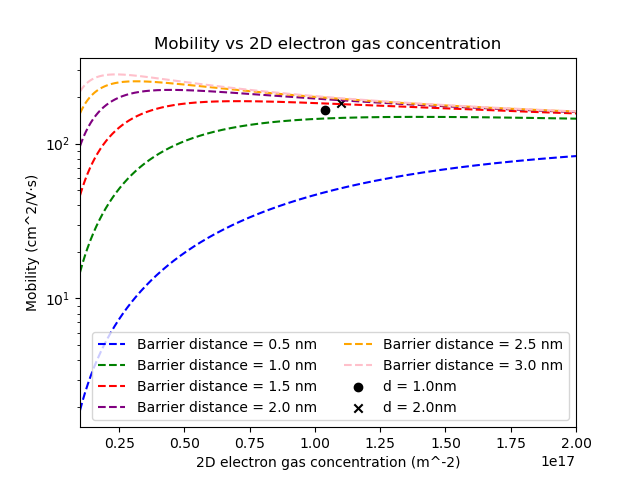

In [15]:
plt.close()
plt.figure()

C = ['blue', 'green', 'red', 'purple', 'orange', 'pink']
for i,d in enumerate(d_imp_barrier_arr):
    plt.plot(n_2DEG_arr, mobility[i], label=f'Barrier distance = {d*1e9} nm', color=C[i], linestyle='--')
    # plt.plot(n_2DEG_arr, u_alloy_arr[i], label='Alloy Disorder', alpha=0.5, color=C[i], linestyle='--')
    # plt.plot(n_2DEG_arr, u_remote_barrier_arr[i], label='Barrier Scattering', color=C[i], linestyle='-.')
    # plt.plot(n_2DEG_arr, u_alloy_arr[i], alpha=0.5, color=C[i], linestyle='--')
    # plt.plot(n_2DEG_arr, u_remote_barrier_arr[i], color=C[i], linestyle='-.')


plt.scatter(1.04e17, 165, label=f'd = 1.0nm', color='black')
plt.scatter(1.1e17, 182, label=f'd = 2.0nm', color='black', marker='x')
plt.xlabel('2D electron gas concentration (m^-2)')
plt.ylabel('Mobility (cm^2/V·s)')
plt.title('Mobility vs 2D electron gas concentration')
# plt.ylim(0,400)
plt.yscale('log')
# plt.xscale('log')
plt.xlim(1e16, 2e17)
plt.legend(ncol=2)
plt.show()